<a href="https://colab.research.google.com/github/Josaphat12-tech/Deep-Learning--And-For-Real-Beginners/blob/main/TensorFLow_Assigment_by_Kikuni_Bitingo_Josaphat_JB_ipynb_txt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install -U tf-models-official


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.2 MB 15.0 MB/s 
     |████████████████████████████████| 43 kB 2.5 MB/s 
     |████████████████████████████████| 1.1 MB 55.2 MB/s 
     |████████████████████████████████| 636 kB 66.7 MB/s 
     |████████████████████████████████| 116 kB 74.6 MB/s 
     |████████████████████████████████| 578.0 MB 15 kB/s 
     |████████████████████████████████| 38.2 MB 231 kB/s 
     |████████████████████████████████| 5.9 MB 55.0 MB/s 
     |████████████████████████████████| 1.3 MB 54.9 MB/s 
     |████████████████████████████████| 238 kB 67.6 MB/s 
     |████████████████████████████████| 438 kB 72.8 MB/s 
     |████████████████████████████████| 1.7 MB 48.1 MB/s 
     |████████████████████████████████| 5.9 MB 55.5 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=6e31cb1694b702f4dd0669741c991f67f0768ad03a6bf907066438b927fcc8

In [9]:
!apt-get install protobuf-compiler python-pil python-lxml python-tk
!pip install Cython
#!pip install jupyter
#!pip install matplotlib

!git clone https://github.com/tensorflow/models.git

%cd /content/models/research

!protoc object_detection/protos/*.proto --python_out=.

# %set_env PYTHONPATH=/content/models/research:/content/models/research/slim

!python object_detection/builders/model_builder_test.py

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
python-tk is already the newest version (2.7.17-1~18.04).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  python-bs4 python-chardet python-html5lib python-olefile
  python-pkg-resources python-six python-webencodings
Suggested packages:
  python-genshi python-lxml-dbg python-lxml-doc python-pil-doc python-pil-dbg
  python-setuptools
The following NEW packages will be installed:
  python-bs4 python-chardet python-html5lib python-lxml python-olefile
  python-pil python-pkg-resources python-six python-webencodings
0 upgraded, 9 newly installed, 0 to remove and 27 not upgraded.
Need to get 303 kB/1,615 kB of archives.
After this operation, 8,916 kB of additional disk space will be used.
Ig


## Imports



In [10]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

print('tensorflow version = ',tf.__version__)

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


tensorflow version =  2.10.0


* change directory to use utils 

In [11]:
!pwd

/content/models/research


In [12]:
%cd ./object_detection/

from utils import label_map_util

from utils import visualization_utils as vis_util

/content/models/research/object_detection


In [13]:
# This is needed to display the images.
%matplotlib inline

## Model preparation
[copy model name from model download link](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models)



In [14]:
# What model to download.  (without .tar.gz)

MODEL_NAME = 'ssd_mobilenet_v1_coco_2018_01_28'
# MODEL_NAME = 'faster_rcnn_resnet101_ava_v2.1_2018_04_30'
# MODEL_NAME = 'ssd_resnet50_v1_fpn_shared_box_predictor_640x640_coco14_sync_2018_07_03'


In [15]:
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

* download model

In [16]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

In [20]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.compat.v1.GraphDef()
  with tf.io.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [21]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

* define function that load image as np.array

In [22]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

## Detection phase

In [23]:
!pwd
print('\nyou must see your uploaded images here\n')
!ls ./test_images/

/content/models/research/object_detection

you must see your uploaded images here

ducky  image1.jpg  image2.jpg  image3.jpg  image_info.txt  snapshot_serengeti


* I add this section to read all jpg image in test_image folder

In [24]:
import glob
TEST_IMAGE_PATHS = []
for filename in glob.iglob('./test_images/*.jpg', recursive=True):
    TEST_IMAGE_PATHS.append(filename)
# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

* this code just read pictures that have 'image' at the first of their name so i comment it & and use above code!

In [ ]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
#PATH_TO_TEST_IMAGES_DIR = 'test_images'
#TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(3, 4) ]

# Size, in inches, of the output images.
#IMAGE_SIZE = (12, 8)

In [33]:
from tensorflow.keras.models import Sequential
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.compat.v1.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.compat.v1.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.compat.v1.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.compat.v1.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

 ### A for loop that read all images in test_images path and feed into the network then show results

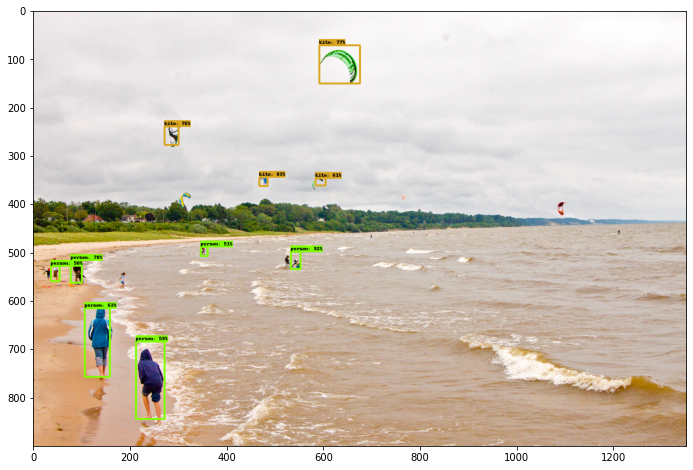

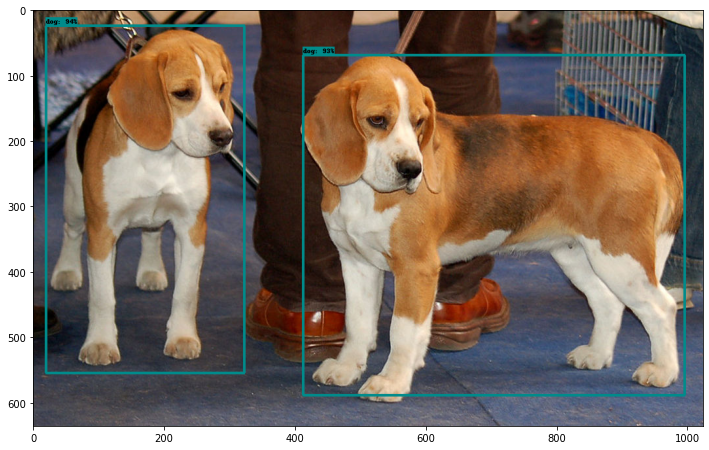

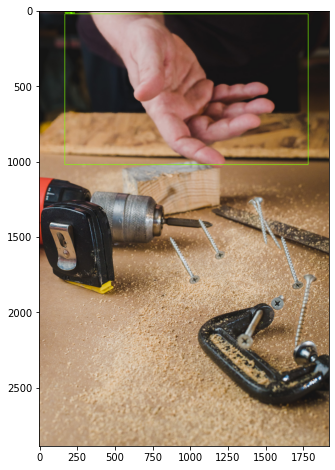

In [35]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=4)
  plt.figure(figsize=IMAGE_SIZE);
  plt.imshow(image_np);
  plt.grid(False);